# Day 4: LightGBM for Trading

## 🎯 Learning Objectives
- Understand LightGBM innovations
- Compare leaf-wise vs level-wise growth
- Apply to high-dimensional data
- Master categorical feature handling

---

## 📚 Theory: LightGBM

### LightGBM vs XGBoost

| Feature | XGBoost | LightGBM |
|---------|---------|----------|
| Tree Growth | Level-wise | Leaf-wise |
| Speed | Slower | Faster |
| Memory | Higher | Lower |
| Categorical | Needs encoding | Native support |

### Leaf-wise Growth
- XGBoost: Grows all leaves at each level
- LightGBM: Grows leaf with highest loss reduction
- More prone to overfitting → use `max_depth` or `num_leaves`

### Key Innovations
1. **Gradient-based One-Side Sampling (GOSS)**: Focus on high-gradient samples
2. **Exclusive Feature Bundling (EFB)**: Bundle sparse features
3. **Histogram-based**: Bin continuous features

### Key Parameters
- `num_leaves`: Max leaves per tree (default 31)
- `max_depth`: Limit depth to prevent overfitting
- `min_data_in_leaf`: Minimum samples per leaf
- `learning_rate`: Shrinkage
- `feature_fraction`: Feature subsampling
- `bagging_fraction`: Row subsampling

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report)
import seaborn as sns
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum
for lag in [1, 5, 10, 20, 60]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

# Volume
df['volume_ratio'] = volume / volume.rolling(20).mean()

# MA ratios
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# MACD
ema_12 = prices.ewm(span=12).mean()
ema_26 = prices.ewm(span=26).mean()
df['macd'] = (ema_12 - ema_26) / prices

# Day of week (categorical)
df['day_of_week'] = df.index.dayofweek

# Month (categorical)
df['month'] = df.index.month

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len(df.columns)-4}, Samples: {len(df)}")

📊 Features: 15, Samples: 1193


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
categorical_cols = ['day_of_week', 'month']

X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 954, Test: 239


In [4]:
# Speed Comparison: LightGBM vs XGBoost
print("\n" + "="*70)
print("SPEED COMPARISON: LightGBM vs XGBoost")
print("="*70)

# XGBoost
start = time.time()
xgb = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.1,
                   random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_time = time.time() - start

# LightGBM
start = time.time()
lgbm = lgb.LGBMClassifier(n_estimators=500, max_depth=5, learning_rate=0.1,
                          random_state=42, verbosity=-1)
lgbm.fit(X_train, y_train)
lgbm_time = time.time() - start

print(f"\nXGBoost training time: {xgb_time:.2f} seconds")
print(f"LightGBM training time: {lgbm_time:.2f} seconds")
print(f"LightGBM speedup: {xgb_time/lgbm_time:.1f}x faster")


SPEED COMPARISON: LightGBM vs XGBoost

XGBoost training time: 0.73 seconds
LightGBM training time: 0.70 seconds
LightGBM speedup: 1.0x faster


In [5]:
# Performance comparison
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

models = [
    ('XGBoost', xgb),
    ('LightGBM', lgbm)
]

print(f"\n{'Model':<15} {'Train Acc':>12} {'Test Acc':>12} {'Test F1':>12} {'AUC':>12}")
print("-" * 65)

for name, model in models:
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_f1 = f1_score(y_test, model.predict(X_test))
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{name:<15} {train_acc:>12.2%} {test_acc:>12.2%} {test_f1:>12.2%} {test_auc:>12.4f}")


PERFORMANCE COMPARISON

Model              Train Acc     Test Acc      Test F1          AUC
-----------------------------------------------------------------
XGBoost              100.00%       52.72%       55.69%       0.5521
LightGBM             100.00%       54.39%       58.24%       0.5596



EFFECT OF num_leaves


 num_leaves  Train Acc  Test Acc
         15        1.0  0.531381
         31        1.0  0.531381
         63        1.0  0.518828
        127        1.0  0.518828
        255        1.0  0.518828


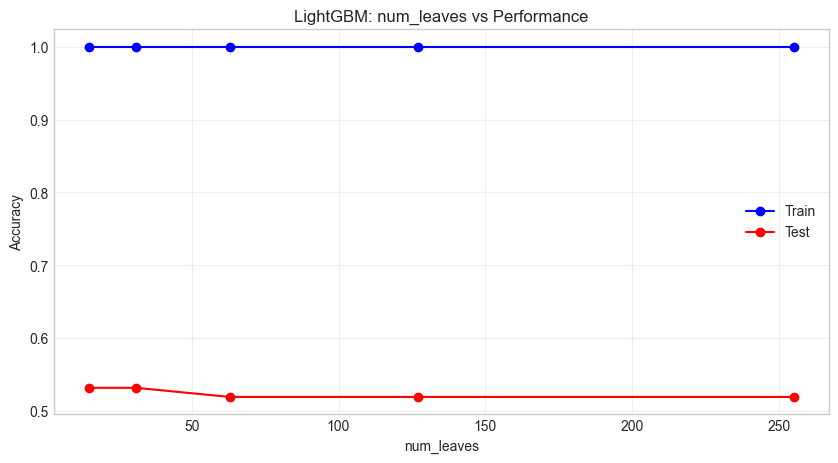

In [6]:
# num_leaves Effect (LightGBM specific)
num_leaves_range = [15, 31, 63, 127, 255]

print("\n" + "="*70)
print("EFFECT OF num_leaves")
print("="*70)

nl_results = []
for nl in num_leaves_range:
    lgbm_nl = lgb.LGBMClassifier(n_estimators=200, num_leaves=nl, learning_rate=0.1,
                                 random_state=42, verbosity=-1)
    lgbm_nl.fit(X_train, y_train)
    
    nl_results.append({
        'num_leaves': nl,
        'Train Acc': accuracy_score(y_train, lgbm_nl.predict(X_train)),
        'Test Acc': accuracy_score(y_test, lgbm_nl.predict(X_test))
    })

nl_df = pd.DataFrame(nl_results)
print(nl_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(nl_df['num_leaves'], nl_df['Train Acc'], 'b-o', label='Train')
plt.plot(nl_df['num_leaves'], nl_df['Test Acc'], 'r-o', label='Test')
plt.xlabel('num_leaves')
plt.ylabel('Accuracy')
plt.title('LightGBM: num_leaves vs Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Categorical Feature Handling
print("\n" + "="*70)
print("CATEGORICAL FEATURE HANDLING")
print("="*70)

# Create LightGBM dataset with categorical features
train_data = lgb.Dataset(X_train, label=y_train, 
                         categorical_feature=categorical_cols)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data,
                       categorical_feature=categorical_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': -1
}

lgbm_cat = lgb.train(params, train_data, num_boost_round=200,
                     valid_sets=[test_data])

y_pred_cat = (lgbm_cat.predict(X_test) > 0.5).astype(int)
print(f"\nWith categorical features: {accuracy_score(y_test, y_pred_cat):.2%}")


CATEGORICAL FEATURE HANDLING



With categorical features: 52.30%


In [8]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [15, 31],
    'max_depth': [5, 7, -1],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)
lgbm_cv = lgb.LGBMClassifier(random_state=42, verbosity=-1)

print("\n⏳ Running GridSearchCV...")
grid_search = GridSearchCV(lgbm_cv, param_grid, cv=tscv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"Best Parameters:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")
print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

lgbm_best = grid_search.best_estimator_


⏳ Running GridSearchCV...

GRID SEARCH RESULTS
Best Parameters:
  feature_fraction: 1.0
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 100
  num_leaves: 31

Best CV Score: 0.5757


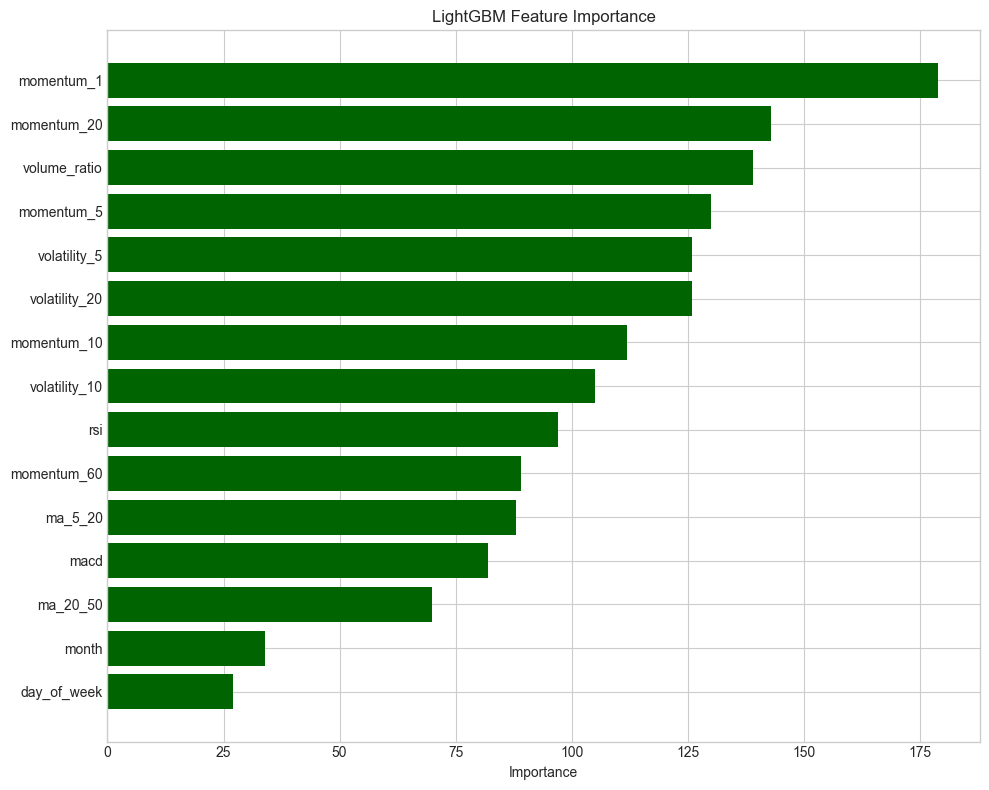


Top 5 Features:
     Feature  Importance
  momentum_1         179
 momentum_20         143
volume_ratio         139
  momentum_5         130
volatility_5         126


In [9]:
# Feature Importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': lgbm_best.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance['Feature'], importance['Importance'], color='darkgreen')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Features:")
print(importance.head().to_string(index=False))

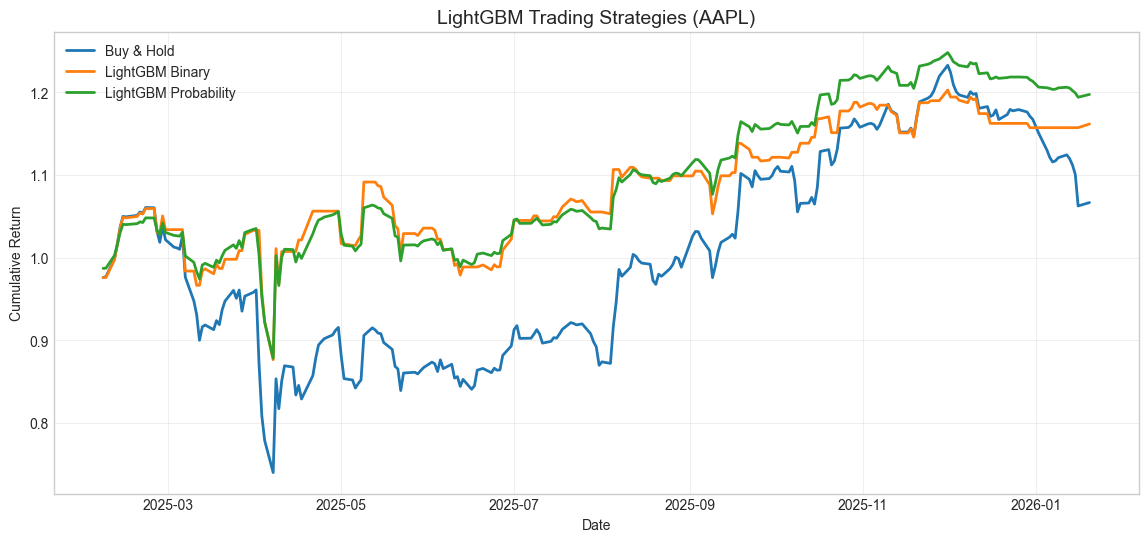

In [10]:
# Trading Strategy Backtest
y_pred = lgbm_best.predict(X_test)
y_proba = lgbm_best.predict_proba(X_test)[:, 1]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Binary
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()

# Probability weighted
backtest['prob_signal'] = y_proba
backtest['prob_return'] = backtest['prob_signal'] * backtest['actual_return']
backtest['prob_cum'] = (1 + backtest['prob_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='LightGBM Binary', linewidth=2)
plt.plot(backtest.index, backtest['prob_cum'], label='LightGBM Probability', linewidth=2)
plt.title(f'LightGBM Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('LightGBM Binary', 'strategy_return', 'strategy_cum'),
    ('LightGBM Probability', 'prob_return', 'prob_cum')
]

print(f"\n{'Strategy':<25} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 60)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<25} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                     Total Ret     Sharpe     Max DD
------------------------------------------------------------
Buy & Hold                       6.67%       0.21    -30.22%
LightGBM Binary                 16.17%       0.54    -17.25%
LightGBM Probability            19.75%       0.74    -16.19%


In [12]:
# Next day prediction
latest = X.iloc[-1:]
pred = lgbm_best.predict(latest)[0]
proba = lgbm_best.predict_proba(latest)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Probability (Down/Up): [{proba[0]:.2%}, {proba[1]:.2%}]")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20

Prediction: 📈 UP
Probability (Down/Up): [26.65%, 73.35%]


---

## 🏢 Real-World Applications

| Company | LightGBM Use Case |
|---------|------------------|
| Microsoft | Large-scale ML |
| Alibaba | High-frequency signals |
| Kaggle Winners | Competition standard |
| Hedge Funds | Fast retraining |

### Key Interview Points
1. **Why LightGBM faster?** - Leaf-wise growth, histogram binning, GOSS
2. **num_leaves vs max_depth?** - num_leaves is primary control; max_depth secondary
3. **Categorical features?** - Native support without encoding
4. **When to use?** - Large datasets, many features, need speed

---
## 📅 Tomorrow: CatBoost